# ADM-HW2 (Domenico Azzarito)

This jupyter notebook focus on the following questions:

[**RQ4**] *Investigating whether users who spend more time using an application give higher or lower ratings.*

   1. Analyze the relationship between the amount of time a user has spent on an application and their review score.

   2. Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

   3. Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.
   
   4. Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

**Bonus** 

Beyond just looking at the numerical ratings, the words users write in their reviews give us valuable insights into how they feel about the application. Let's analyze these review texts using sentiment analysis.

   1. Perform sentiment analysis on the review texts in the top 3 languages and classify them as **positive**, **negative**, or **neutral**.

   2. What is the distribution of sentiment across all reviews? 

   3. Does the sentiment analysis align with whether the application is recommended or not? Explain any insights from this comparison.

   4. Is there a correlation between the sentiment of a review and the number of helpfulness votes it receives? Provide an analysis of the results and discuss potential trends.



In [49]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('data/steam_reviews.csv', nrows= 5436842) # read the 25% of the data

### Question 4.1

Analyze the relationship between the amount of time a user has spent on an application and their review score.

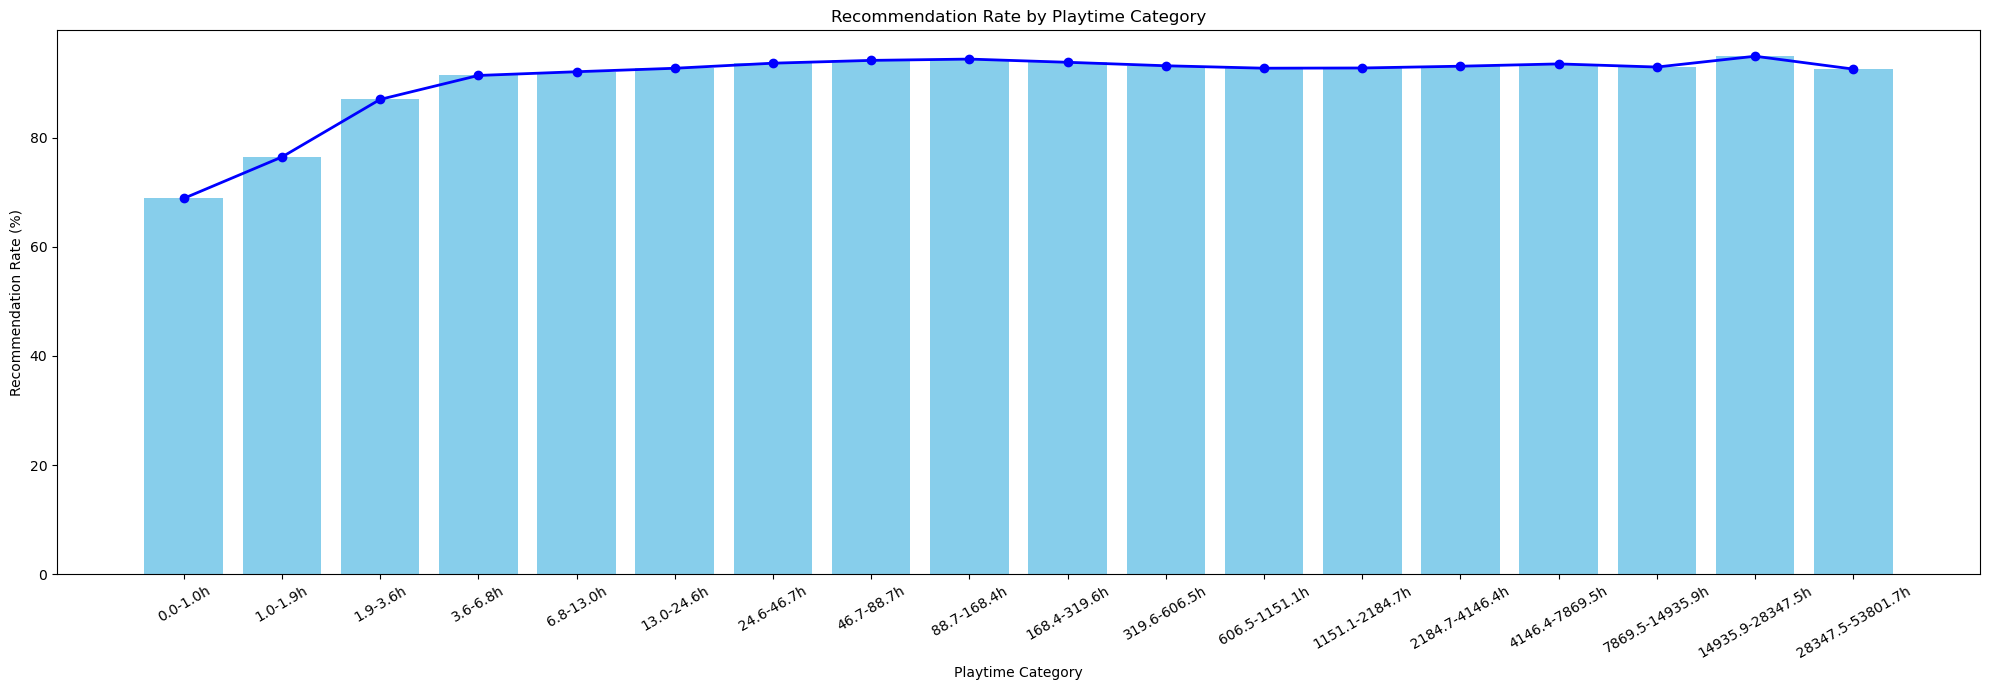

In [101]:
# To perform this analysis, we related play time to recommendation rate. To do this, we divided the reviews into categories associated with a minimum and maximum amount of time spent playing.
# For each category, the rate of positive reviews associated with it was calculated. 

# Remove the reviews with 0 playtime at review
df = df.dropna(subset=['author.playtime_at_review'])

# Convert the playtime at review to hours
df['playtime_at_review_hours'] = df['author.playtime_at_review'] / 60

# Define the bins and labels for the playtime categories, using a logarithmic scale in order to considering more significant differences in the lower playtime values and fewer in the higher ones
num_bins = 18
max_playtime = df['playtime_at_review_hours'].max()
bins = np.logspace(np.log10(1), np.log10(max_playtime), num=num_bins)

# Add 0 to the beginning of the bins array to include players with 0 playtime
bins = np.insert(bins, 0, 0)

# Create labels for the bins
labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}h' for i in range(len(bins)-1)]

# Create a new column to store the playtime category for each review
df['playtime_category'] = pd.cut(df['playtime_at_review_hours'], bins=bins, labels=labels, include_lowest=True)

# Calculate the recommendation rate for each playtime category (percentage of positive reviews)
result = df.groupby('playtime_category',  observed=False)['recommended'].mean().reset_index()
result['recommendation_rate'] = result['recommended'] * 100 # Convert to percentage

# Plot the recommendation rate for each playtime category using a bar plot to visualize the differences between categories and a line plot to show the trend
plt.figure(figsize=(20, 7))
plt.bar(result['playtime_category'], result['recommendation_rate'], color='skyblue', align='center')
plt.plot(result['playtime_category'], result['recommendation_rate'], marker='o', color='blue', linewidth=2) 
plt.title('Recommendation Rate by Playtime Category')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=30) # Rotate the x-axis labels for better readability
plt.tight_layout() # Adjust the plot to fit the labels
plt.show()

### Question 4.2

Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

From the analysis carried out and the graph obtained, experienced users generally tend to give a positive review to the application, maintaining a steady trend. 


### Question 4.3
Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.

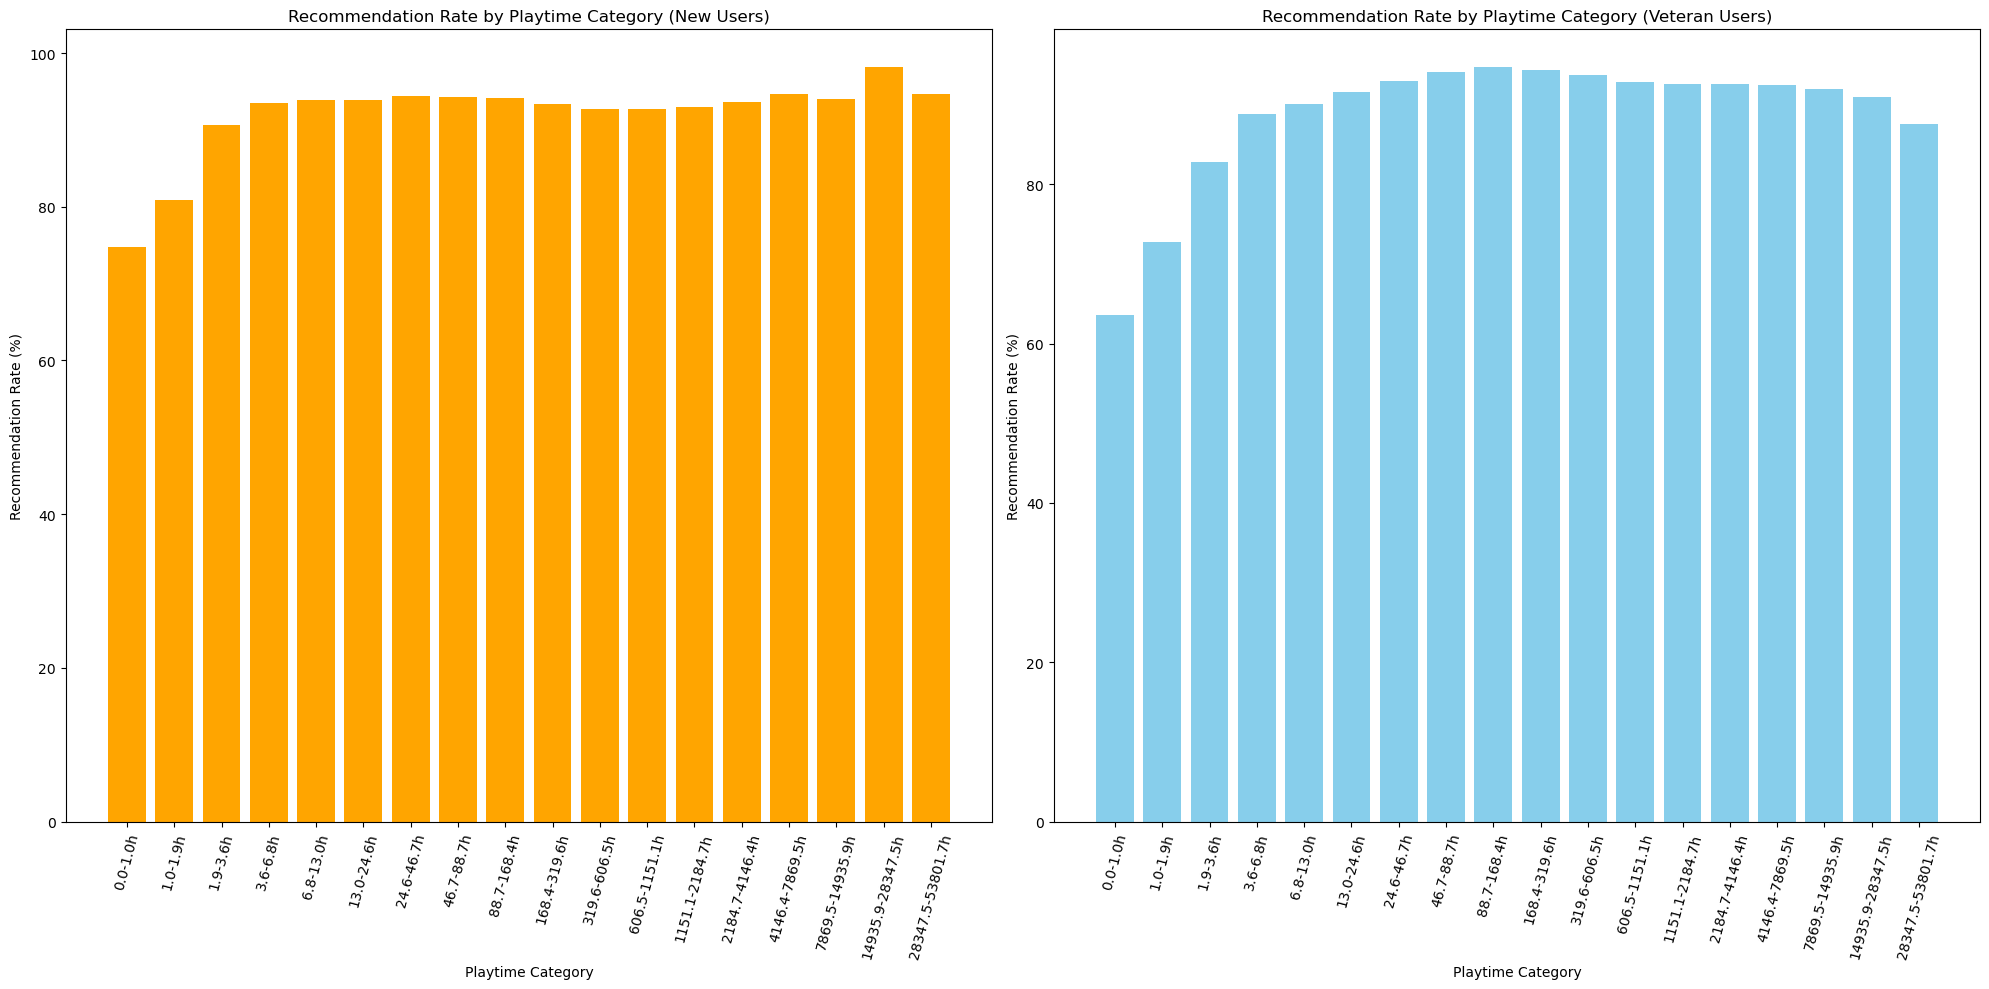

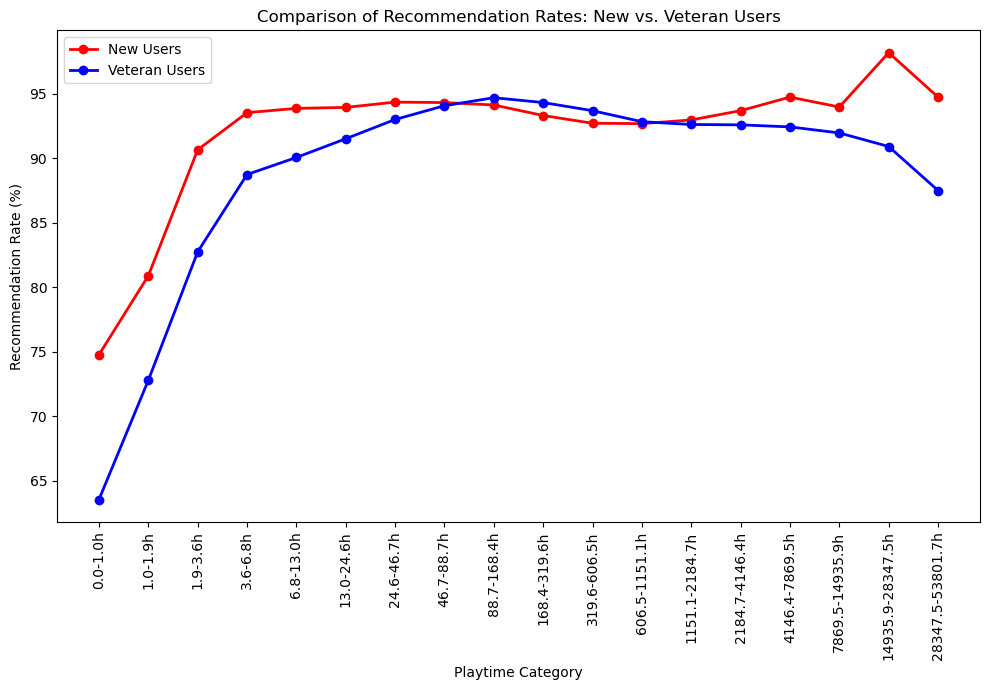

In [123]:

# To analyze the relationship between the number of games owned by a user and their review, we divided the users into two categories: veterans and new users.
# The threshold for the number of games owned was set as the median value of the 'author.num_games_owned' column.
# Users with a number of games owned greater than the threshold were classified as veterans, while those with fewer games were classified as new users.
experience_threshold = df['author.num_games_owned'].median()
df['user_experience'] = np.where(df['author.num_games_owned'] > experience_threshold, 'Veteran', 'New')

# Calculate the recommendation rate for each playtime category and user experience group
result = df.groupby(['user_experience', 'playtime_category'], observed=False)['recommended'].mean().reset_index()
result['recommendation_rate'] = result['recommended'] * 100 # Convert to percentage

# Plot the recommendation rate for each playtime category and user experience group 
plt.figure(figsize=(20, 10))

# Plot for new users 
plt.subplot(1, 2, 1)
new_users = result[result['user_experience'] == 'New']
plt.bar(new_users['playtime_category'], new_users['recommendation_rate'], color='orange')
plt.title('Recommendation Rate by Playtime Category (New Users)')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=75)

# Plot for veteran users
plt.subplot(1, 2, 2)
veteran_users = result[result['user_experience'] == 'Veteran']
plt.bar(veteran_users['playtime_category'], veteran_users['recommendation_rate'], color='skyblue')
plt.title('Recommendation Rate by Playtime Category (Veteran Users)')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation= 75)

plt.tight_layout()
plt.show()

# Create a combined plot for comparison between new and veteran users, in order to visualize the differences in recommendation rates for each playtime category
plt.figure(figsize=(10, 7))
plt.plot(new_users['playtime_category'], new_users['recommendation_rate'], marker='o', linewidth=2, color='red', label='New Users')
plt.plot(veteran_users['playtime_category'], veteran_users['recommendation_rate'], marker='o', linewidth=2, color='blue', label='Veteran Users')
plt.title('Comparison of Recommendation Rates: New vs. Veteran Users')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

As we can see from the graphs, there is no significant difference between the two groups. Both new and veteran users tend to recommend the app at similar rates across different playtime categories. New users show slightly higher recommendation rates early on, possibly due to novelty or lower initial expectations, but over time ratings from both groups become more similar as playtime increases, suggesting a balanced feature set and consistent experience.

This can be proven by the t-test, a statistical method used to compare the means of two groups. It determines if there's a significant difference between these means or if the difference is likely due to chance. The test calculates a t-statistic and compares it to a critical value to assess statistical significance. In this case, we compare the recommendation's rates for New Users and Expert Users.

In [117]:
# Perform a t-test to compare the recommendation rates between new and veteran users for each playtime category
from scipy.stats import ttest_ind

new_user_rates = new_users['recommendation_rate']
veteran_user_rates =  veteran_users['recommendation_rate']

t_stat, p_val = ttest_ind(new_user_rates, veteran_user_rates)

print(f'T-test results for comparison of recommendation rates between new and veteran users:')
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

# Define the significance level
alpha = 0.05

# Check if the null hypothesis can be rejected
if p_val < alpha:
    print('Null hypothesis rejected: There is a significant difference in recommendation rates between new and veteran users.')
else:
    print('Null hypothesis cannot be rejected: There is no significant difference in recommendation rates between new and veteran users.')


T-test results for comparison of recommendation rates between new and veteran users:
T-statistic: 1.3704290232201104
P-value: 0.17953392907346014
Null hypothesis cannot be rejected: There is no significant difference in recommendation rates between new and veteran users.


### Question 4.4 

Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

Based on the statistical analysis results, the interpretation suggests no significant difference in recommendation rates between new and veteran users of the app. Both groups show similar recommendation patterns across various playtime categories, with consistently high rates (mostly above 80%). This indicates a well-balanced user experience that caters to both newcomers and long-term users.

The LLM suggests several additional factors that could explain rating patterns for users who spend more time on the app:

1. Discovery of advanced features
2. Social engagement within the app
3. Content saturation
4. App performance over extended use
5. Evolving user needs
6. Update frequency and quality

These factors could potentially influence user satisfaction and ratings in various ways, depending on how they're implemented and experienced by users.

To validate the interpretations provided by the LLM, we could employ several methods:

1. Conduct user surveys targeting different user segments
2. Analyze feature usage data
3. Perform sentiment analysis on user reviews
4. Implement A/B testing for different features or content
5. Track cohort behavior over time
6. Assess the impact of app updates on ratings
7. Consider external factors that might influence app usage and satisfaction

By combining these validation methods, we can gain a more comprehensive understanding of what drives long-term user satisfaction and ratings. This multi-faceted approach would help mitigate biases and provide a robust foundation for interpreting user behavior and preferences, ultimately informing app development and user experience optimization decisions.